<a href="https://colab.research.google.com/github/roman-mikhaylov/repo_sinergiya/blob/main/ML_5_15_Mikhaylov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

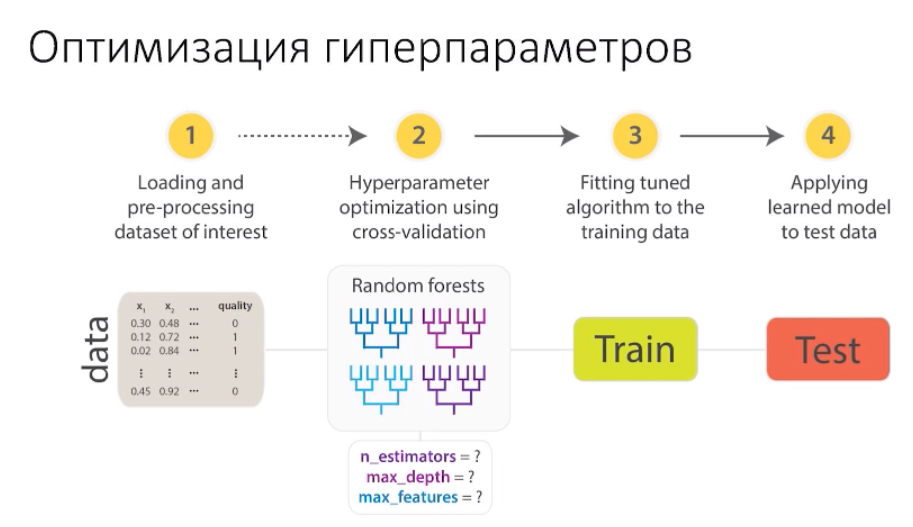

**Практикум**

Оптимизация гиперпараметров линйной регрессии

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [2]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [4]:
import numpy as np
import pandas as pd
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,ElasticNet
from scipy.stats import uniform
from sklearn.metrics import mean_squared_log_error
import sklearn
from sklearn.model_selection import RandomizedSearchCV

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy_2.csv')
data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,air_temperature1,wind_direction_sin,wind_direction_cos,hour
0,2016-01-30 08:00:00,43.6839,8.3,0.0,6.1,0.0,1019.0,2.1,-2.3,-0.642788,-0.766044,8
1,2016-01-31 05:00:00,37.5408,12.8,0.0,10.0,0.0,1021.9,0.0,-1.1,0.000000,1.000000,5
2,2016-01-31 17:00:00,52.5571,20.6,0.0,11.7,0.0,1020.9,1.5,1.7,0.939693,-0.342020,17
3,2016-04-08 14:00:00,59.3827,21.7,2.0,14.4,0.0,1015.1,3.1,2.8,-0.939693,-0.342020,14
4,2016-05-01 19:00:00,448.0000,31.1,0.0,17.2,0.0,1016.1,4.1,1.1,0.984808,-0.173648,19


нормализация

In [10]:
data_norm = MinMaxScaler().fit_transform(data[["air_temperature",
                                               "sea_level_pressure",
                                               "cloud_coverage",
                                               "dew_temperature",
                                               "precip_depth_1_hr",
                                               "wind_speed",
                                               "wind_direction_sin",
                                               "wind_direction_cos",
                                               "air_temperature1"]])
df = pd.DataFrame(data_norm)
df[1] = df[1].interpolate()
df[6] = df[6].interpolate()
df[7] = df[7].interpolate()
data_norm = df.to_numpy()

модель линейной регрессии

без регуляции

In [11]:
# функция ошибки RMSLE
def rmsle_err(y, y_pred):
  return ((np.log(1 + y) - np.log(1 + y_pred))**2).mean()**0.5


In [12]:
x = data_norm
y = data['meter_reading']
model = LinearRegression().fit(x, y)
print ('RMSLE: {0:.5}'. format(rmsle_err(y, model.predict(x))))
#print("Коэффициенты: ", model.coef_, model.intercept_)

RMSLE: 0.21287


**Случайная оптимизация**

используем случайеый поиск для двух гиперпараметров - alpha и l1_ratio

In [13]:
model_el = ElasticNet()

зададим случайные выборки для гиперпараметров

In [14]:
distributions = dict(alpha=uniform(loc=0, scale=1), l1_ratio = uniform(loc=0, scale=1))

In [15]:
clf = RandomizedSearchCV(model_el, distributions, random_state=0) # случайный поиск по сетке наилучшей комбинации гиперпараметров

проведем поиск

In [16]:
search = clf.fit(x,y)
print(search.best_params_)

{'alpha': 0.02021839744032572, 'l1_ratio': 0.832619845547938}


создадим оптимальную модель и оценим её точность

In [17]:
model_el = ElasticNet(alpha=search.best_params_['alpha'], l1_ratio=search.best_params_['l1_ratio']).fit(x, y)
print ('RMSLE: {0:.5}'. format(rmsle_err(y, model_el.predict(x))))

RMSLE: 0.21271


**OPTUNA**

Объединим процесс обучения и проверки модели с гиперпараметрами в один шаг

In [18]:
def objective(trial):
  alpha = trial.suggest_float('alpha', 1e-8, 1, log=True)
  l1_ratio = trial.suggest_float('l1_ratio', 1e-3, 1, log=True)
  regressor_obj = ElasticNet(alpha = alpha, l1_ratio=l1_ratio)
  regressor_obj.fit(x,y)
  y_pred = regressor_obj.predict(x)
  return mean_squared_log_error(y,y_pred)

В коде используется библиотека Optuna для оптимизации функции objective с использованием 1000 испытаний (n_trials=1000). Метод create_study() создает новый Study объект, который представляет текущую оптимизацию. Метод optimize() запускает процесс оптимизации, ища наилучшие параметры для функции objective.

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

In [20]:
print(study.best_params)

{'alpha': 0.0021621910304897643, 'l1_ratio': 0.001379888954708822}


In [21]:
model_optuna = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio']).fit(x, y)
print ('RMSLE: {0:.5}'. format(rmsle_err(y, model_optuna.predict(x))))

RMSLE: 0.21252


**Задание спикера**

Построить модели ElasticNet с разным набором параметров погоды и выяснить како набор погодных параметров оптимизируется в наименьшей метрике RMSLE через Optuna

ранее было выяснено, что наиболее корреляция с meter_read есть у параметров давления и температуры.

In [ ]:
data_norm1 = MinMaxScaler().fit_transform(data[["air_temperature",
                                               "sea_level_pressure",
                                               ]])
df = pd.DataFrame(data_norm)
df[1] = df[1].interpolate()
df.info()

In [26]:
data_norm1 = df.to_numpy()

In [64]:
x = data_norm1
y = data['meter_reading']
model = LinearRegression().fit(x, y)
print ('RMSLE: {0:.5}'. format(rmsle_err(y, model.predict(x))))
#print("Коэффициенты: ", model.coef_, model.intercept_)

RMSLE: 0.21287


In [65]:
model_el1 = ElasticNet()
model_el1.fit(x,y)

ElasticNet()

In [68]:
def objective(trial):
  alpha = trial.suggest_float('alpha', 1e-8, 1, log=True)
  l1_ratio = trial.suggest_float('l1_ratio', 1e-3, 1, log=True)
  regressor_obj = ElasticNet(alpha = alpha, l1_ratio=l1_ratio)
  regressor_obj.fit(x,y)
  y_pred = regressor_obj.predict(x)
  return mean_squared_log_error(y,y_pred)

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

In [69]:
model_optuna1 = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio']).fit(x, y)
print ('RMSLE: {0:.5}'. format(rmsle_err(y, model_optuna1.predict(x))))

RMSLE: 0.21252


добавим скорость изменения температуры

In [70]:
data_norm2 = MinMaxScaler().fit_transform(data[["dew_temperature",
                                               "sea_level_pressure",
                                               ]])
df = pd.DataFrame(data_norm)
df[1] = df[1].interpolate()
data_norm2 = df.to_numpy()

In [71]:
data_norm2 = df.to_numpy()

In [72]:
model_el2 = ElasticNet()
model_el2.fit(x,y)

ElasticNet()

In [ ]:
study2 = optuna.create_study()
study2.optimize(objective, n_trials=1000)

In [77]:
model_optuna1 = ElasticNet(alpha=study2.best_params['alpha'], l1_ratio=study2.best_params['l1_ratio']).fit(x, y)
print ('RMSLE: {0:.5}'. format(rmsle_err(y, model_optuna1.predict(x))))

RMSLE: 0.21252


In [78]:
x = data_norm1
y = data['meter_reading']
model1 = LinearRegression().fit(x, y)
print ('RMSLE: {0:.5}'. format(rmsle_err(y, model1.predict(x))))
#print("Коэффициенты: ", model.coef_, model.intercept_)

RMSLE: 0.21287


чуть лучше

следующая параметры. температура, давление и ветер

In [95]:
data_norm2= MinMaxScaler().fit_transform(data[["air_temperature",
                                               "wind_speed"
                                               ]])
#df = pd.DataFrame(data_norm2)
#df[2] = df[2].interpolate()
#df[3] = df[3].interpolate()
#df[7] = df[7].interpolate()
#data_norm2 = df.to_numpy()
#df.info()

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5411 non-null   float64
 1   1       5411 non-null   float64
dtypes: float64(2)
memory usage: 84.7 KB


In [96]:
x = data_norm2
y = data['meter_reading']
model2 = LinearRegression().fit(x, y)
print ('RMSLE: {0:.5}'. format(rmsle_err(y, model2.predict(x))))
#print("Коэффициенты: ", model.coef_, model.intercept_)

RMSLE: 0.21909


In [97]:
model_el3 = ElasticNet()
model_el3.fit(x,y)

ElasticNet()

In [ ]:
study3 = optuna.create_study()
study3.optimize(objective, n_trials=1000)

In [99]:
model_optuna3 = ElasticNet(alpha=study3.best_params['alpha'], l1_ratio=study3.best_params['l1_ratio']).fit(x, y)
print ('RMSLE: {0:.5}'. format(rmsle_err(y, model_optuna3.predict(x))))

RMSLE: 0.21909


одинаково. вывод: температура и давление

**Практикум для самостоятельной работы**

1.Опишите, для чего используют оптимизацию гиперпараметров?

Оптимизация гиперпараметров - это процесс настройки значений гиперпараметров для улучшения производительности модели машинного обучения. Гиперпараметры - это параметры, которые определяют структуру и поведение модели, но не могут быть автоматически определены на основе обучающих данных.

Оптимизация гиперпараметров используется для поиска наилучшей комбинации гиперпараметров, что позволяет модели показывать наилучшие результаты на тестовых данных. Это важно, так как неправильные значения гиперпараметров могут привести к переобучению, недообучению или низкой обобщающей способности модели.

Использование оптимизации гиперпараметров включает следующие этапы:

Определение гиперпараметров модели: для каждой модели машинного обучения есть набор гиперпараметров, которые необходимо определить. Например, в случае нейронной сети гиперпараметрами могут быть количество скрытых слоев, количество нейронов в каждом слое, скорость обучения и т.д.
Выбор метрики для оценки производительности модели: чтобы определить, насколько хорошо модель работает, необходимо выбрать метрику, которая будет использоваться для оценки ее производительности. Распространенные метрики включают точность, полноту, F1-меру и ROC-кривую.
Выбор метода оптимизации гиперпараметров: существует множество методов оптимизации гиперпараметров.

Как правило, при достижении целей при построении модели ML, есть возможность донастроить показатели прогнозирования ещё более точно чем получилось. Для этого пользуются оптимизацией гиперпараметров. Важно! Если заданной точности мы не достигли, то, с помощью оптимизации, улучшить результат, скорее всего,  не получится! В этом случае рекомендуется использовать другую модель.

2.Какой риск возможен при оптимизации?

В Machine Learning оптимизация может привести к переобучению модели, когда она запоминает данные вместо того, чтобы учиться на них. Это может привести к снижению обобщающей способности модели и увеличению вероятности возникновения overfitting. Чтобы избежать этого, необходимо проводить валидацию модели и использовать методы регуляризации.

3.Перечислите методы оптимизации.

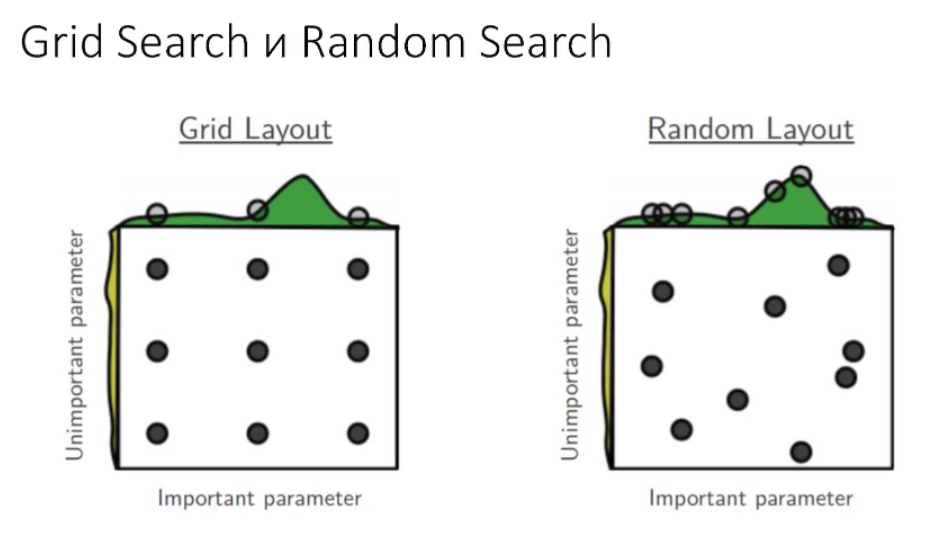

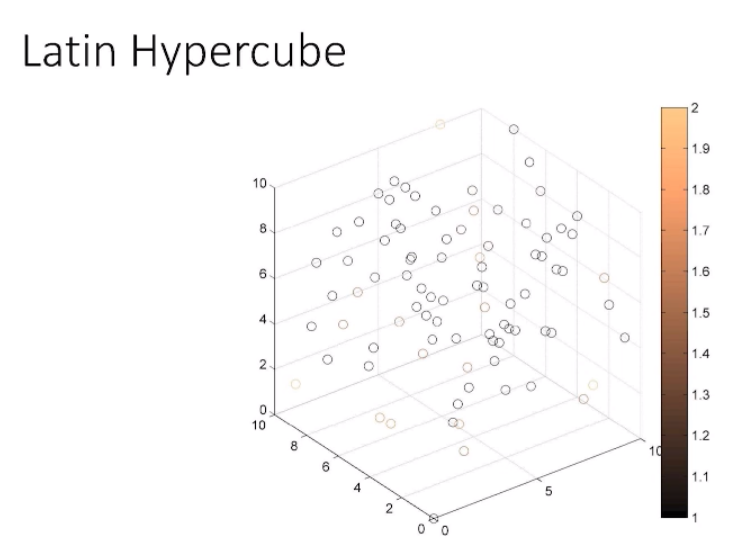

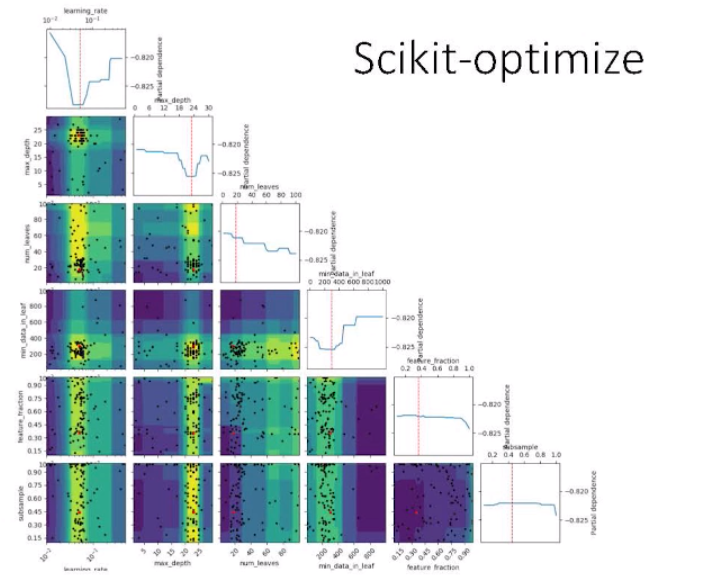

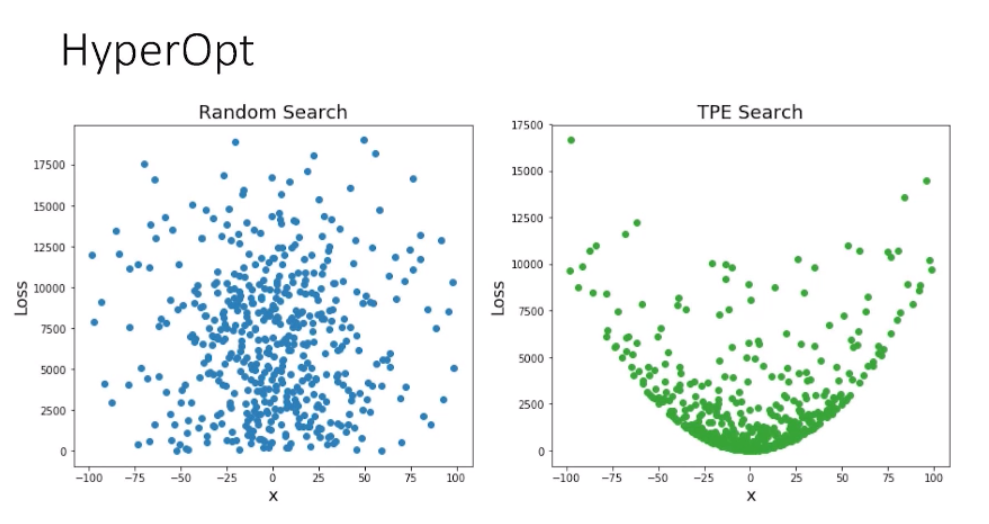

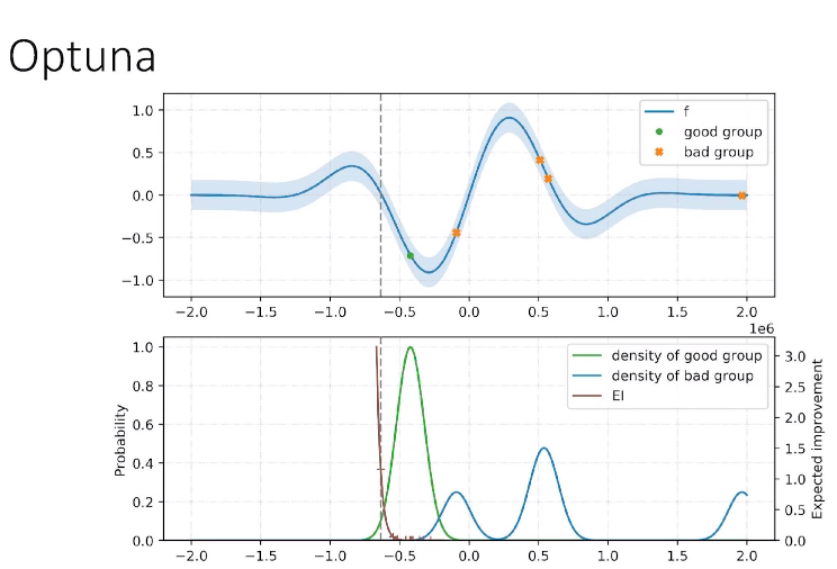

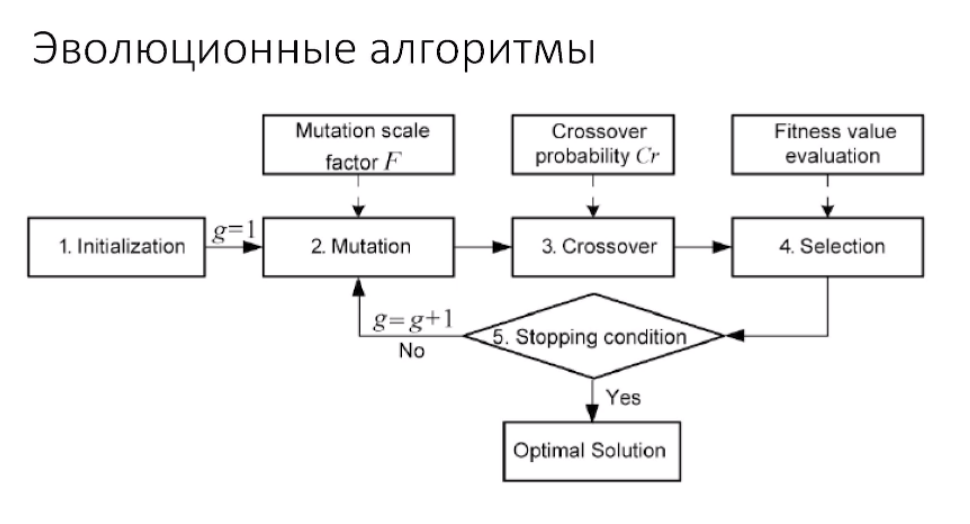